<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/0719/03_(practice)YOLOv4_train_with_Darknet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv4 trainning with Darknet

YOLO (You Only Look Once)

    - YOLO는 1-stage detector로 빠르게 이미지에서 객체를 탐지하는 모델.
    - 높은 정확도 보다는 기존 모델들에 근접한 정확도를 가지면서 더 많은 양의 이미지를 처리할 수 있는 기능을 목표로 하여 개발됨. 따라서 실시간 객체 탐지에 주로 사용됨.
    - Joseph Redmon가 YOLO ver1, ver2, ver3를 개발하였지만 YOLO가 군사적 목적에 의해 사용되는 것에 회의를 느끼고 개발을 중단.
    - 따라서 v4, v5는 다른 개발자들이 개발.

YOLO ver4
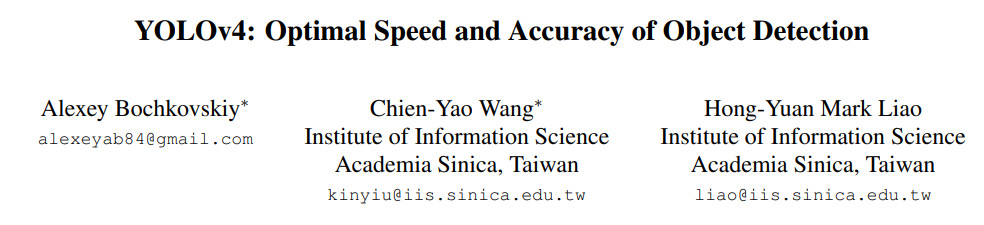


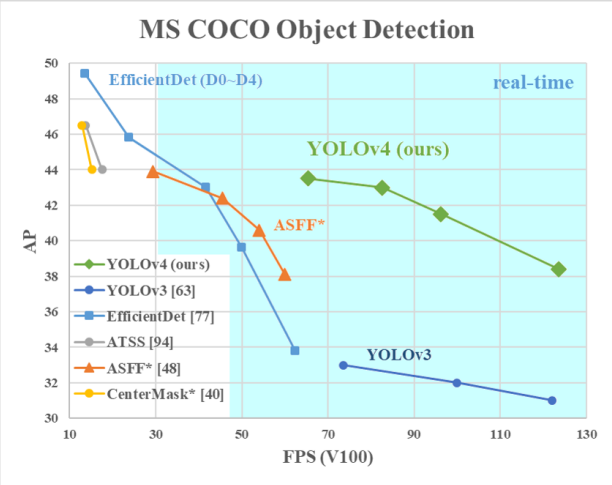




* YOLO의 각 시리즈는 이전 버전의 한계를 개선하며 개발되어 왔다.
* 그래프에서 볼 수 있듯이 scaled YOLO ver4는 ver3에 비하여 속도는 유사하지만 정확도 측면에서 많이 개선된 것을 볼 수 있다.  
* YOLO ver 4는 성능을 개선하기 위한 여러 기법을 논문에서 소개하였는데 이러한 기법들은 크게 BOF(Bag Of Freebies)와 BOS(Bag Of Specials)로 구분할 수 있다.
* BOF로는 Data Augmentation, Semantic Distribution Bias, Bounding Box Regression 등이 있다.
* BOS는 SPP, RFB, SE, SAM, SFAM, ASFF 등이 있다.
* 자세한 내용은 논문에서 읽어볼 수 있다.

    이미지 출처 + 논문 주소: https://arxiv.org/pdf/2004.10934.pdf

In [1]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline

* YOLOv4를 통해 object detection을 수행하기 위하여 YOLOv4의 개발자 AlexeyAB의 Darknet repository를 사용하여보자.

Darknet

    - YOLO의 개발자 Joseph Redmon이 개발한 신경망 프레임워크.
    - YOLO, RBB 등 DNN(Deep Neural Network)들을 학습시키고 실행시킬 수 있는 프레임워크
    - C, CUDA로 작성된 오픈 소스이며, C로 개발되었기 때문에 연산이 빠른 장점이 있음.
    - CPU 및 GPU 연산을 지원

* Darknet은 YOLOv4의 Backbone으로 사용된다.
* Backbone은 입력 이미지를 feature map으로 변형시키는 역할을 담당한다.
* object detector은 주로 Backbone과 Head로 구분될 수 있으며, Head에서는 Backbone에서 추출한 feature map을 사용하여 classfication과 Regression을 수행한다.
* 추상화가 잘 되어 있어 사용하기는 편하나 일정부분 이상 커스텀이 어렵다
* 코드를 최소화 시켰다. config 파일을 통해 코드 변경이 가능하다

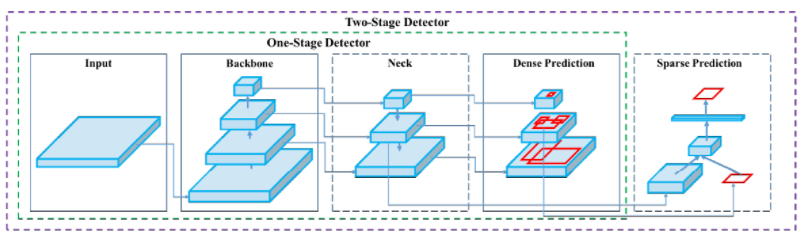

이미지 출처: https://arxiv.org/pdf/2004.10934.pdf

## 0) git clone

`git clone [git repo url] (local dir)`

* 주소를 입력한 Git repository의 가장 최신 버전을 복제한다.
* repository는 프로젝트 코드를 저장하는 가상 저장공간이다.
* git repo url에는 클로닝하고자 하는 repository의 주소를 입력한다.

주소 예시)

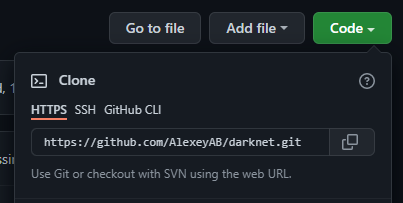
* local dir에는 복제본의 저장위치를 지정한다. (생략 가능)

In [2]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15530, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15530 (delta 6), reused 10 (delta 4), pack-reused 15514
Receiving objects: 100% (15530/15530), 14.21 MiB | 15.84 MiB/s, done.
Resolving deltas: 100% (10418/10418), done.


* git clone 실행 후에는 다음과 같이 darknet의 프로젝트 폴더가 생성된다.

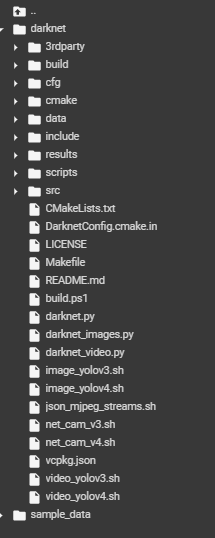

## 1) custom dataset 다운로드

In [3]:
# roboflow에서 마스크 데이터 다운로드

!curl -L "https://public.roboflow.com/ds/lCDk2oQ1NC?key=Cyfy8rt1GB" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   895  100   895    0     0   2220      0 --:--:-- --:--:-- --:--:--  2215
100 3786k  100 3786k    0     0  2045k      0  0:00:01  0:00:01 --:--:-- 6821k
Archive:  roboflow.zip
 extracting: test/phplpE73q_jpg.rf.bd81cab9f8ff2674ce2e58278f7d37fa.jpg  
 extracting: train/1580128422_jpg.rf.182b42586c5d5ea95a75c17449c48ad3.jpg  
 extracting: test/1579924271_jpg.rf.be5b27c2b2801bccc191e6dbd9bfccca.jpg  
 extracting: train/w1240-p16x9-5f8aa310737f8e0e6c43d95a68a82b03b6f60106_jpg.rf.104bedd5b3bad4a0d0a453203e0617a3.jpg  
 extracting: train/pollution-mask-CE5HYF_jpg.rf.21d8ab9eb19a6cd10956c96a0cfeff57.jpg  
 extracting: test/shutterstock_1627199179_jpg.rf.8432d033a37b3d142ec4ffcede508c7d.jpg  
 extracting: train/1-200102094256105_png.rf.22dcc10b1378b9ea7f05c83d04c052aa.jpg  
 extracting: test/RTX7CCFN_jpg.rf.66ed5c5054f30d933d19ab3d56

* 다음과 같이 train, test dataset 폴더가 생성되었는지 확인

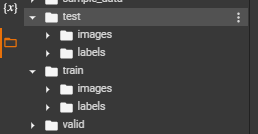

* YOLO를 훈련시키려면 필요한 3가지 데이터가 있다.


    1. data

    2. cfg

    3. weight

* 해당 파일들을 차례로 생성하여 보자.



## 2) .data파일 생성
이 파일의 내용에는 모델에 쓰일 모든 자료의 위치가 들어있어야한다.

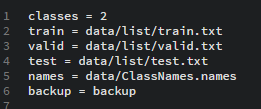

- 데이터 병합
- train.txt, valid.txt, test.txt, ClassNames.names 생성
- mask_data.data 생성

In [4]:
## 경로 딕셔너리 저장
foldernames = ['test', 'train', 'valid']

content_path = {}

for folder in foldernames:
    content_path[folder] = []
    floderpath = os.path.join(f'/content/{folder}')
    for names in os.listdir(floderpath):
        if names != '_darknet.labels':
            content_path[folder].append(names)

In [5]:
import shutil
import os
## 데이터 병합
# 폴더 생성
os.mkdir('/content/images', 0o777)
# 폴더 경로
merge_path = os.path.join('/content', 'images')

for name, paths in content_path.items():
    for path in paths:
        dir_path = '/content/'+name+'/'+path
        # 이미지 있는 폴더 경로
        shutil.move(dir_path, merge_path)

In [6]:
## train.txt, valid.txt, test.txt, ClassNames.names 생성

for folder, paths in content_path.items():
    f = open(f'/content/darknet/data/{folder}.txt', 'w')
    for path in paths:
        if path[-3:] == 'jpg':
            f.write(merge_path+'/'+path+'\n')

    f.close()


In [7]:
%cat /content/test/_darknet.labels

mask
no-mask

In [8]:
c = open('/content/darknet/data/ClassNames.names', 'w')
c.write('mask\n')
c.write('no-mask\n')
c.close()

In [9]:
# # 편의상 label 파일 삭제
# !rm test/_darknet.labels
# !rm train/_darknet.labels
# !rm valid/_darknet.labels

In [10]:
## mask_data.data 생성
data = open('/content/darknet/data/mask_data.data', 'w')
data.write("classes = 2\n")
data.write("train = /content/darknet/data/train.txt\n")
data.write("valid = /content/darknet/data/valid.txt\n")
data.write("test = /content/darknet/data/test.txt\n")
data.write("names = /content/darknet/data/ClassNames.names\n")
data.write("backup = /content/darknet/backup/")
data.close()

## 3) .cfg 파일 수정

* cfg 파일은 neural network의 일반 정보를 저장하는 구성 파일이다.
* 우리가 사용할 YOLOv4의 정보는 yolov4-custom.cfg에 저장되어 있다.
* 마스크 착용 여부를 구분하는 task에 맞추어 yolov4-custom.cfg를 수정하자.

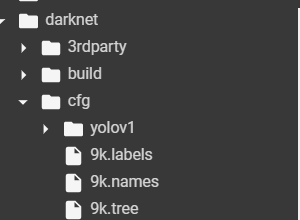

* darknet 폴더 아래 cfg 폴더를 클릭 -> yolo4-custom 더블 클릭



* cfg 파일을 더블클릭하면 파일 내용을 편집/탐색할 수 있도록 사이드에 파일이 열린다.

* cfg 파일 : 모델 아키텍처 저장된 파일, 파일을 열어서 원하는 설정값으로 변경이 가능하다
 - (예시)
   - |[net] : [ ] >> 레이어 /층
   - | # Testing >> # : 주석, 사용되지 않음
   - |#batch=1
   - |#subdivisions=1
   - |# Training
   - |batch=64
   - |subdivisions=16
   - |width=608
   - |height=608
   - |channels=3
   - |momentum=0.949
   - |decay=0.0005
   - |angle=0
   - |saturation = 1.5
   - |exposure = 1.5
   - |hue=.1
   -
   - |learning_rate=0.001
   - |burn_in=1000
   - |max_batches = 500500 >> 카테고리 수의 2000배 (추천), 줄이거나 늘릴 수 있는데 늘리면 오래걸린다
   - |policy=steps >> 러닝레이트 스케줄링 (step으로 설정한 것)
   - |steps=400000,450000 >> 러닝레이트 스탭 수, 모델 성능이 너무 낮으면 값을 변경했을 때 성능이 늘어날 수도 있다
   - |scales=.1,.1
   -
   - |#cutmix=1
   - |mosaic=1
   -
   - |#:104x104 54:52x52 85:26x26 104:13x13 for 416
   - ....
   - |[convolutional] >> [ ] : 레이어/ 층
   - |batch_normalize=1
   - |filters=32
   - |size=3
   - |stride=1
   - |pad=1
   - |activation=mish >> relu가 발전한 함수 mish, adam 같이 자주 쓰이는 activation
   - ....
   - |[convolutional] >> 마지막 conv 층
   - |size=1
   - |stride=1
   - |pad=1
   - |**filters=255 **>> (카테고리 수 + 5) X3 : (anchor 값) == 오브젝트 라벨값(카테고리수) + x,y,w,h,(각 1) + confidence(물체를 잡았는지 확률 값, 1개)>> 카테고리수 + 4(x,y,w,h,), +1(confidence) , mask anchor 3개 = *3, **모델을 쓸 때마다 바꿔줘야 한다, 같은 데이터는 미리 설정한 파일을 짓다운해서 써도 된다
   - |activation=linear
   -
   - |**[yolo]** >> yolo 모델
   - |**mask = 6,7,8**>> mask(앵커 박스)가 9종류가 있는데 크기의 종류를 9종류로 잡아서 작은 것 중에 종/횡/비 3종류(제일/ 중간/ 큰), 중간/큰 것도 각 3종류 잡는다 >> 학습을 원활하게 하기 위해서 바운딩 박스의 초기값을 나눠 놓은 것
   - |**anchors =12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401** >> 2개가 한 세트(w,h), 앵커 박스의 좌표 값 , 마지막 6개(3좌표)가 mask 6, 7, 8 >> 박스가 크다 = 큰 물체 잡는다
   - |**classes=2** >> 맞춰야 할 카테고리 수, yes /no가 아니라 바운드 박스가 어디를 얼마나 잡느냐가 과제.  yes라고 잡은 바운드 박스 값일 때 틀렸다고 해서 no가 아니다(배경일 수도 있고 다른 것을 수도 있다), no라고 잡은 바운드 박스 값을 따로 구해줘야 한다
   - | ....

In [11]:
# 우리가 사용할 YOLOv4의 구조를 살펴보자.
%cat /content/darknet/cfg/yolov4-custom.cfg

[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=16
width=608
height=608
channels=3
momentum=0.949
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 500500
policy=steps
steps=400000,450000
scales=.1,.1

#cutmix=1
mosaic=1

#:104x104 54:52x52 85:26x26 104:13x13 for 416

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
act

다음과 같이 yolov4-custom.cgf 파일을 수정한다.
* subdivision = 16
* width = 416
* height = 416
* max_batches = num_classes * 2000 = 2 * 2000 = 4000
* steps = max_batches * 0.8, max_batches * 0.9 = 3200, 3600
* yolo layer 마다 classes=2
* yolo layer 앞에 있는 convolutional layer 마다 filers = (num_classes + 5) * 3 = 21

In [23]:
# 변경사항이 반영이 되었는지 확인하여보자.
%cat /content/darknet/cfg/yolov4-custom.cfg

[net]
# Testing
#batch=1
#subdivisions=16
# Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.949
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 4000
policy=steps
steps=3200, 3600
scales=.1,.1

#cutmix=1
mosaic=1

#:104x104 54:52x52 85:26x26 104:13x13 for 416

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=mish

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=mish

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=mish

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activat

## 4) .weight 다운로드


`!wget [옵션] [url]`
* 웹 상의 파일을 다운로드하는 리눅스 명령어이다.
* wget => web get



In [29]:
%cd '/content/darknet/'

/content/darknet


https://github.com/AlexeyAB/darknet/releases

In [ ]:
# yolov4 pre-trained weights 다운로드
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [15]:
# /content/darknet/yolov4.conv.137 : 현재경로

## 5) darknet 구축

* 기존 파일을 그대로 사용하는 것이 아니라 Makefile을 수정하여 옵션을 변경하여 보자.
* Makefile은 darknet 프로젝트 폴더 내에 존재하며, darknet 구축을 위한 옵션이 저장되어 있다.

(변경 전)

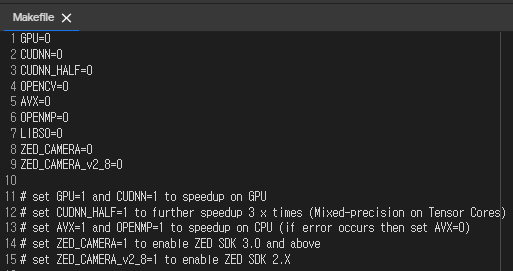

`!sed [옵션] '명령어' [파일] `
* sed는 리눅스 os에서 비대화형 모드로 [파일]에 해당하는 텍스트 파일을 편집한다.

`-i`
* inplace로 명령어를 수행하는 옵션이다.
* -i.back으로 옵션을 설정할 경우 오리지널 파일의 백업 데이터가 생성된다.

`'s/검색할 문자열/치환할 문자열'`
* s(=subsitute command)는 치환을 수행하는 명령어이다.
* [파일]에서 조건에 일치하는 문자열을 모두 찾아 치환할 문자열로 대체한다.

In [31]:
# GPU, OPENCV, LIBSO을 true로 설정
# s(문자라는 의미)/before(바꾸기 전)/after(바꿀 것)/
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile # OPENCV=0을 찾아서 OPENCV=1로 바꿔라
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

In [32]:
%cat /content/darknet/Makefile

GPU=1
CUDNN=1
CUDNN_HALF=1
OPENCV=1
AVX=0
OPENMP=0
LIBSO=1
ZED_CAMERA=0
ZED_CAMERA_v2_8=0

# set GPU=1 and CUDNN=1 to speedup on GPU
# set CUDNN_HALF=1 to further speedup 3 x times (Mixed-precision on Tensor Cores) GPU: Volta, Xavier, Turing and higher
# set AVX=1 and OPENMP=1 to speedup on CPU (if error occurs then set AVX=0)
# set ZED_CAMERA=1 to enable ZED SDK 3.0 and above
# set ZED_CAMERA_v2_8=1 to enable ZED SDK 2.X

USE_CPP=0
DEBUG=0

ARCH= -gencode arch=compute_35,code=sm_35 \
      -gencode arch=compute_50,code=[sm_50,compute_50] \
      -gencode arch=compute_52,code=[sm_52,compute_52] \
	    -gencode arch=compute_61,code=[sm_61,compute_61]

OS := $(shell uname)

# GeForce RTX 3070, 3080, 3090
# ARCH= -gencode arch=compute_86,code=[sm_86,compute_86]

# Kepler GeForce GTX 770, GTX 760, GT 740
# ARCH= -gencode arch=compute_30,code=sm_30

# Tesla A100 (GA100), DGX-A100, RTX 3080
# ARCH= -gencode arch=compute_80,code=[sm_80,compute_80]

# Tesla V100
# ARCH= -gencode arch=compute_7

(변경 후)

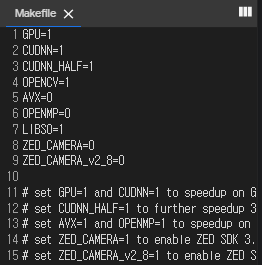

* OpenCV는 오픈 소스 컴퓨터 비전 라이브러리이다.
* Libso는 so 라이브러리 파일(=동적 라이브러리 파일)을 만드는 옵션이다. LIBSO=1(=True)로 설정하면 darknet.so 파일이 생성되며, 파이썬으로 darknet을 작동시키는 것이 가능해진다.

* darknet을 구축하여보자.
* !make로 Makefile을 컴파일할 수 있다.

In [33]:
# 위의 변경된 옵션으로 makefile을 컴파일하면 darknet.py 사용이 가능해진다.
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
  946 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
 1147 |             if (iteration_old == 

## 6) transfer learning
- model : yolo-v4
- dataset : mask-wearing

In [34]:
%cd /content/darknet

/content/darknet


In [35]:
!pwd /content/darknet/data/mask_data.data

/content/darknet


In [ ]:
# custom dataset으로 YOLO 학습 (아래 코드는 model.fit(x, y) 코드라고 이해하면 된다.)
# data 필요, model 구조와 세부설정값, model weights
!./darknet detector train data/mask_data.data cfg/yolov4-custom.cfg yolov4.conv.137 -dont_show -map

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.398974), count: 11, class_loss = 2.386970, iou_loss = 0.203640, total_loss = 2.590609 
 total_bbox = 710601, rewritten_bbox = 0.031804 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.538428), count: 69, class_loss = 21.228165, iou_loss = 49.608650, total_loss = 70.836815 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.480396), count: 58, class_loss = 15.548938, iou_loss = 7.412337, total_loss = 22.961275 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.472038), count: 6, class_loss = 1.047655, iou_loss = 0.210720, total_loss = 1.258376 
 total_bbox = 710734, rewritten_bbox = 0.031798 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.607585), count: 45, class_loss = 15.134034, iou_loss = 35.325794, total_loss = 50.459827 
v3 (i

* 100 iteration 마다 backup 폴더에 yolov4-custom_last.weights으로 weights가 저장된다. 학습이 중간에 중단되는 경우 해당 weights로부터 학습을 재게하면된다.


In [22]:
## 학습 재게
# %cd /content/darknet
# !./darknet detector train data/mask_data.data cfg/yolov4-custom.cfg backup/yolov4-custom_last.weights -dont_show -map

## 7) 학습결과 저장

다음 파일을 저장한다.
* ClassNames.names
* test.txt
* train.txt
* valid.txt
* mask_data.data
* yolov4_custom_best.weights